In [1]:
import torch
import matplotlib.pyplot as plt
import glob
from utils import imageSize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchmetrics import Accuracy
from torch.utils.tensorboard import SummaryWriter


In [2]:

# Assuming you want to create a DataLoader for image datasets
transform = transforms.Compose([
    transforms.Resize((imageSize, imageSize)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])



# Create a dataset and dataloader
dataset = datasets.ImageFolder('data', transform=transform)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
val_size = test_size // 2
test_size = test_size - val_size
batch_size = 32
num_workers = torch.get_num_threads()
train_dataset,val_dataset ,test_dataset = random_split(dataset, [train_size, val_size,test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [3]:
clases = dataset.classes
classes =[longClass.split('-')[0] for longClass in dataset.classes]

In [4]:
@torch.no_grad()
def showImages(images,labels,predLabels=None):
    fig = plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        tlt = classes[labels[i]] if predLabels is None else f'Target: {classes[labels[i]]} \nPrediction{classes[predLabels[i]]}'
        plt.title(tlt)
        plt.axis('off')
    return fig

In [5]:
images, labels = next(iter(val_loader))
print(images.shape, labels.shape)

torch.Size([32, 3, 200, 200]) torch.Size([32])


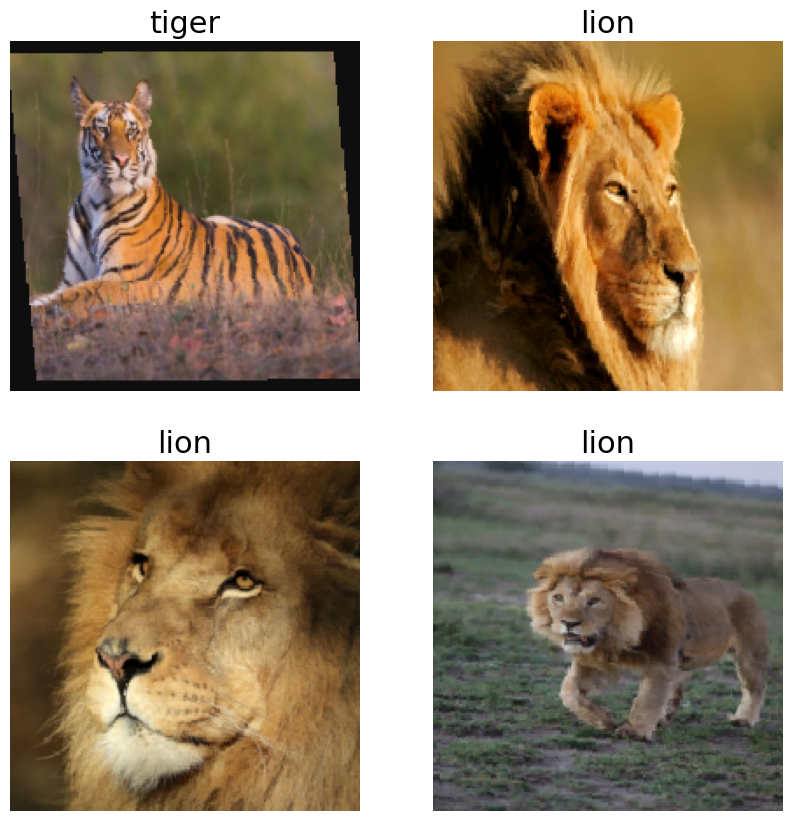

In [6]:
_ = showImages(images, labels)

# Create model

In [7]:
from model_zoo import animalModel,Animal2

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
num_classes = len(classes)
model = Animal2(3, num_classes)
num_epochs = 10
valSteps = len(val_loader)
writer = SummaryWriter(comment='Weighted Cross Entropy Loss')
class_weights = torch.tensor([1.,1.5,1.,1.,1.,1.]).to(device)
lossF = nn.CrossEntropyLoss(weight=class_weights)
learningRate = 1e-3
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=momentum)
accMetric = Accuracy(task='multiclass',num_classes=num_classes)
writer.add_hparams({'lr':learningRate,'optim':'Adam','Batch Size':batch_size,'momentum':momentum,'image size':imageSize,'train ratio':train_size*100/len(dataset),'validation ratio':val_size*100/len(dataset),'test ratio':test_size*100/len(dataset)},{'Number of epochs':num_epochs})

In [18]:
trainsteps  = len(train_loader)

In [19]:
model = model.to(device)
writer.add_graph(model, images.to(device))
accMetric.to(device)

MulticlassAccuracy()

In [20]:
model.fit(train_loader,val_loader,criterion=lossF,optimizer=optimizer,device=device,writer=writer,accMetric=accMetric,epochs=num_epochs,num_classes=num_classes)

Epoch: 0
Training Loss: 1.7656 Training Accuracy: 0.2285
Validation Loss: 1.7289482355117798 Validation Accuracy: 0.2916666567325592
Epoch: 1
Training Loss: 1.6743 Training Accuracy: 0.3854
Validation Loss: 1.6706472635269165 Validation Accuracy: 0.3090277910232544
Epoch: 2
Training Loss: 1.6296 Training Accuracy: 0.4329
Validation Loss: 1.580632209777832 Validation Accuracy: 0.4548611044883728
Epoch: 3
Training Loss: 1.5707 Training Accuracy: 0.4742
Validation Loss: 1.573145866394043 Validation Accuracy: 0.4444444477558136
Epoch: 4
Training Loss: 1.5414 Training Accuracy: 0.5012
Validation Loss: 1.5486418008804321 Validation Accuracy: 0.5347222089767456
Epoch: 5
Training Loss: 1.5217 Training Accuracy: 0.5251
Validation Loss: 1.512668251991272 Validation Accuracy: 0.5243055820465088
Epoch: 6
Training Loss: 1.5188 Training Accuracy: 0.5316
Validation Loss: 1.5656481981277466 Validation Accuracy: 0.4895833432674408
Epoch: 7
Training Loss: 1.4900 Training Accuracy: 0.5518
Validation Loss

In [21]:
lossF = nn.CrossEntropyLoss()
model.fit(train_loader,val_loader,criterion=lossF,optimizer=optimizer,device=device,writer=writer,accMetric=accMetric,epochs=num_epochs,num_classes=num_classes)


Epoch: 0


KeyboardInterrupt: 